In [17]:

Classification, Segmentation = 0, 1
ml_types = ['Classification', 'Segmentation']
batch_sizes = [150, 15]

ml_type = Segmentation

version = '0.4'


batch_size=batch_sizes[ml_type]

epochs=2
learning_rate = (10**(-4))*1.5

training=False
resume_training=False

base='/mnt/z9-slide-storage/VipsML'

modelname=base + '/weights/Vips{}_{}'.format(ml_types[ml_type], version)


In [2]:

import pyvips as Vips

if ml_type == Segmentation:
    origs=[Vips.Image.new_from_file(base+'/00-orig.tif')]
    masks=[Vips.Image.new_from_file(base+'/00-mask_3.tif')]
elif ml_type == Classification:
    origs=[Vips.Image.new_from_file(base+'/0'+str(n)+'-orig.tif') for n in range(1,4)]
    masks=[Vips.Image.new_from_file(base+'/0'+str(n)+'-mask.tif') for n in range(1,4)]

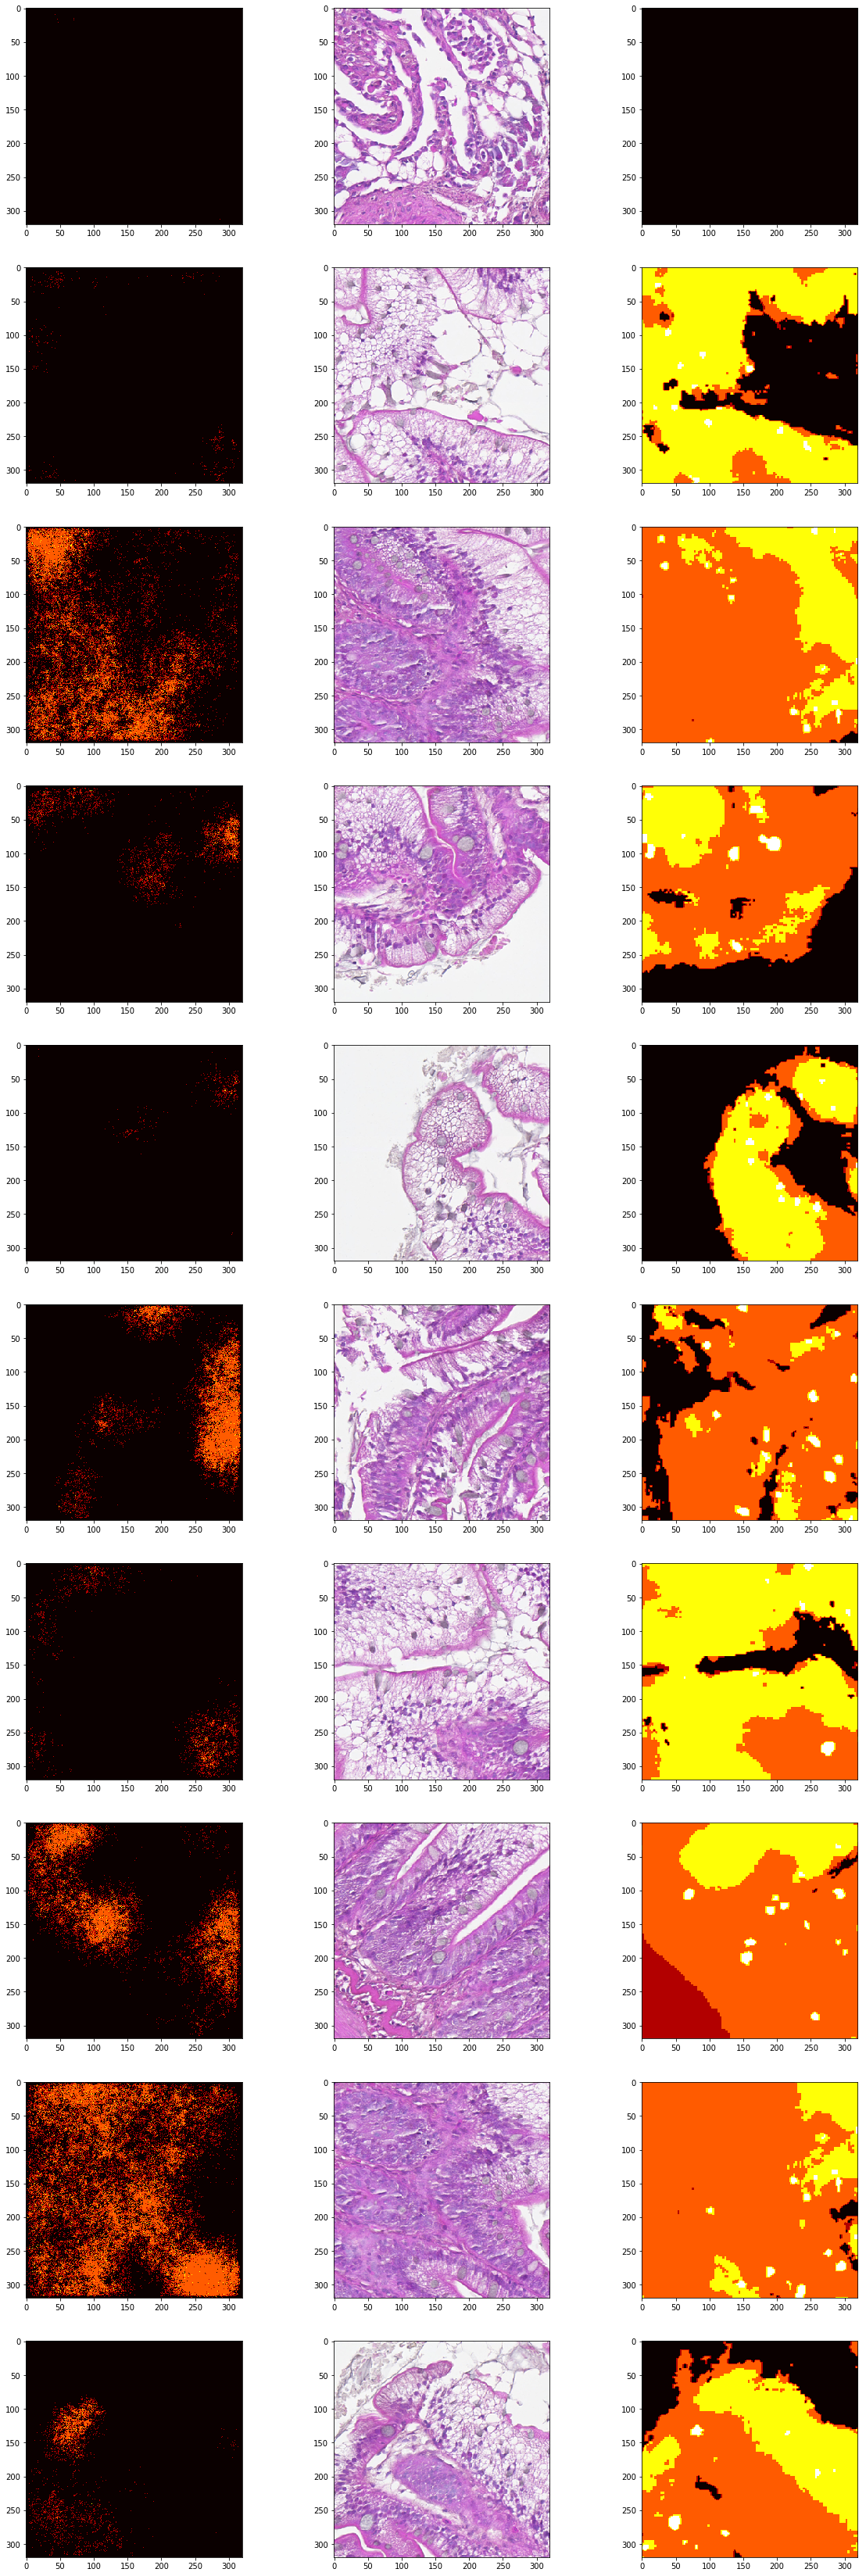

In [19]:
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
import numpy as np
from random import choice, shuffle
from models import SmallerVGGNet, SegNet

import VipsML
#from importlib import reload
#reload(VipsML)

models = [SmallerVGGNet, SegNet]
CNNModel = models[ml_type]

image_classes = [VipsML.VipsClassificationML, VipsML.VipsSegmentationML]
ImageClass = image_classes[ml_type]


from keras.optimizers import SGD
opt = SGD(lr=learning_rate, decay=learning_rate / epochs)

images = [ImageClass(orig,mask,overlap=0.5,padding=32) for orig, mask in zip(origs,masks)]

generator=VipsML.VipsGroupML(images, batch_size=batch_size)

model = CNNModel(generator.shape, generator.classes)

if training:    
    model.compile(loss="categorical_crossentropy", optimizer=opt,
        metrics=["categorical_accuracy"])    
    
    if resume_training:
        model.load_weights(modelname)    

    checkpointer = ModelCheckpoint(filepath=modelname + "_tmp", verbose=1,save_best_only=True)
    
    trainer, validator = generator.split_generators(0.1)
    
    H = model.fit_generator(trainer,validation_data=validator,epochs=epochs, callbacks=[checkpointer])
    
    model.save(modelname)

if not training:
    
    model.load_weights(modelname)
    
    n_controls=10

    rs=list(range(generator.images[0].total_frames))
    f, axarr = plt.subplots(n_controls,3,figsize=(20,6*n_controls))
    n=0
    
    test_ids=[]
    test_images=[]
    
    while n < n_controls:        
        i=choice(rs)
        
        orig=generator.images[0].get_single(i)
        
        if orig.mean() > 230:
            continue        
        test_ids += [i] 
        test_images += [orig]
        n+=1
    
    predictions=model.predict(np.asarray(test_images))
    
    for n,i in enumerate(test_ids):
        predicted=predictions[n].reshape((generator.shape[0],generator.shape[1],generator.classes))
        axarr[n][0].imshow(np.argmax(predicted,axis=2),vmax=4,vmin=0,cmap='hot')
        axarr[n][1].imshow(test_images[n])
        axarr[n][2].imshow(np.argmax(generator.images[0].mask.get(i),axis=2),vmax=4,vmin=0,cmap='hot')

In [11]:

#from importlib import reload
#import models
#import VipsML

#reload(VipsML2)
#reload(models)
whole=Vips.Image.new_from_file(base+'/00-orig.tif')
s2=ImageClass(whole)
model = CNNModel(s2.shape, 5)
model.load_weights(modelname ) 
#s2=VipsML2.VipsSegmentationML(whole)
im=s2.predict_model(model, batch_size=batch_size)


100%|██████████| 35/35 [00:25<00:00,  1.28it/s]


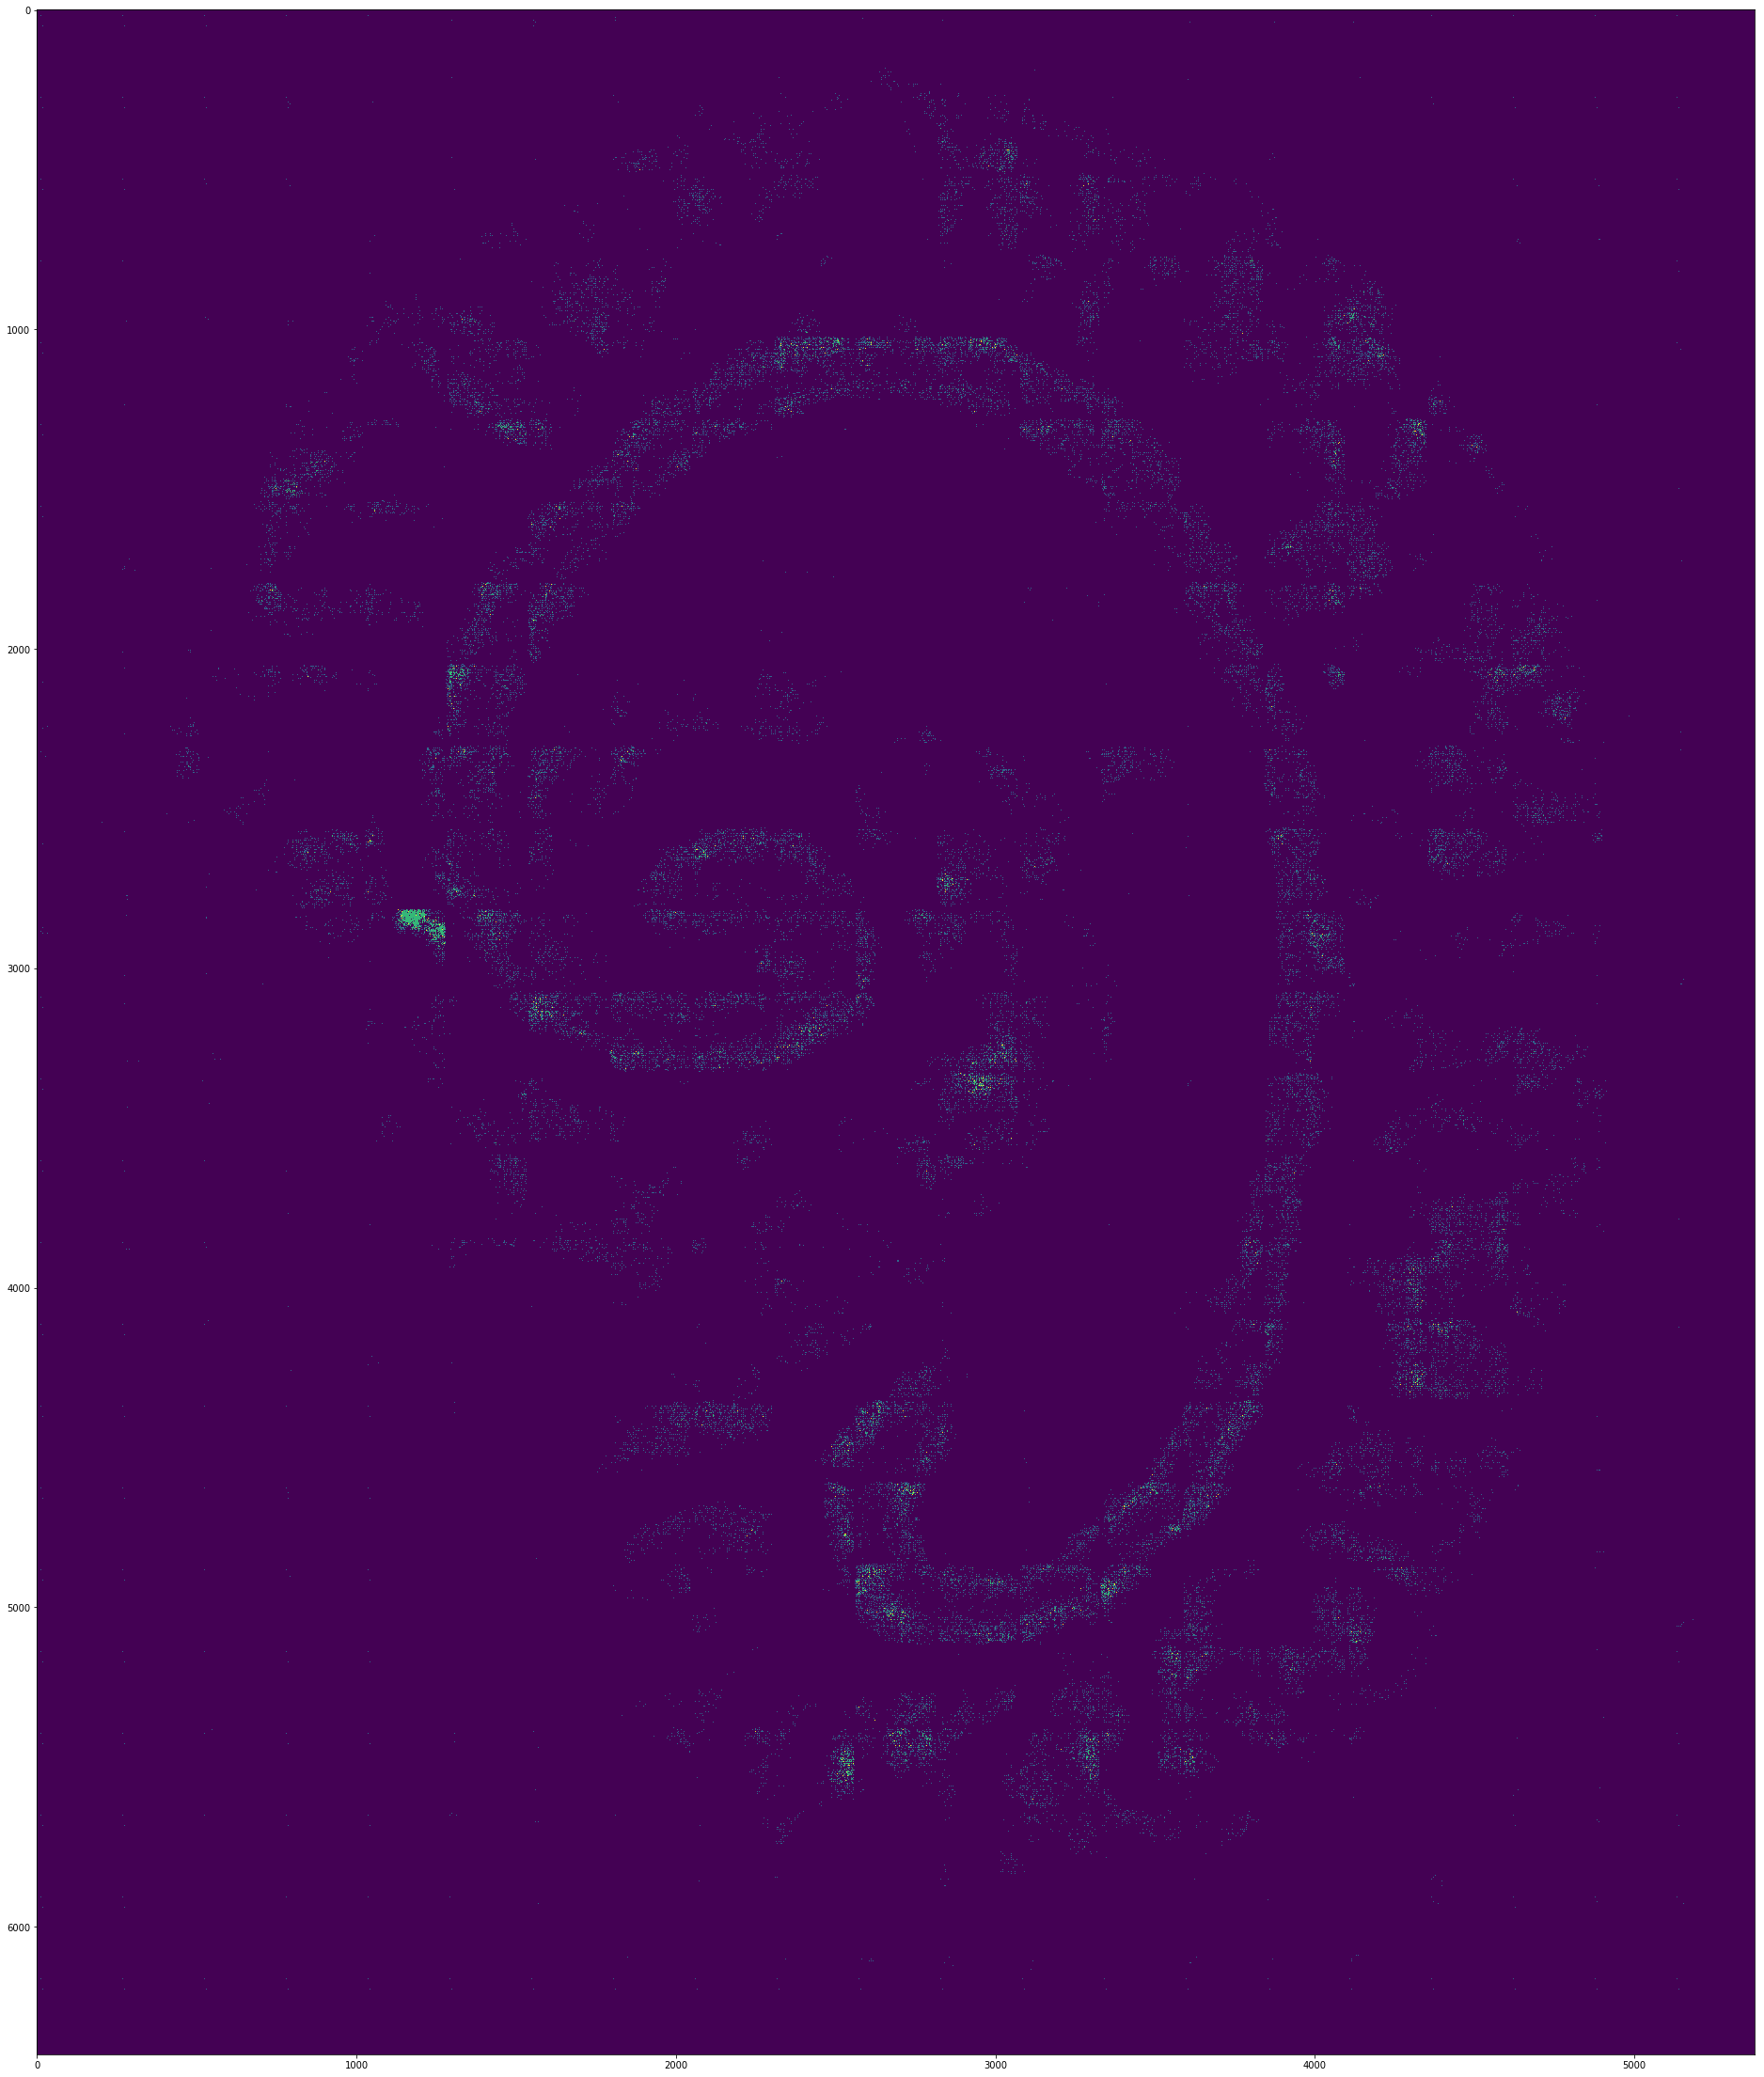

In [12]:
import numpy as np
from numpy import histogram
from numpy import frombuffer, uint32, uint8,float32, squeeze
from matplotlib.pyplot import imshow, figure
from PIL import Image
figure(figsize=(40,40))
#imsave(base+'/../00-mask_2.tif',im.astype(np.uint8))
#im = Image.fromarray(im.astype(np.uint8), mode='P')


imshow(im.astype(np.uint8))

In [35]:
#im.save(base+'/../00-mask_2.tif')
m2=Vips.Image.new_from_file(base+'/../00-mask_2.tif').resize(5266/1756,vscale=3)
m2.write_to_file(base+'/../00-mask_3.tif')